In [28]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [2]:
ins_data = pd.read_pickle('../../data/cleaned/full_insurance.pkl')
ins_data

,age,sex,bmi,children,smoker,region,charges
0,19,0.494768,27.900,0,0.204783,0.242900,16884.92400
1,18,0.505232,33.770,1,0.795217,0.272048,1725.55230
2,28,0.505232,33.000,3,0.795217,0.272048,4449.46200
3,33,0.505232,22.705,0,0.795217,0.242900,21984.47061
4,32,0.505232,28.880,0,0.795217,0.242900,3866.85520
...,...,...,...,...,...,...,...
1333,50,0.505232,30.970,3,0.795217,0.242900,10600.54830
1334,18,0.494768,31.920,0,0.795217,0.242152,2205.98080
1335,18,0.494768,36.850,0,0.795217,0.272048,1629.83350
1336,21,0.494768,25.800,0,0.795217,0.242900,2007.94500


****standardization****

- ***age quantile transformation***

In [22]:
qt_transformer = QuantileTransformer(n_quantiles=100,
                                     output_distribution='uniform',
                                     random_state=0)

In [23]:
after_transform_age = qt_transformer.fit_transform(np.asarray(ins_data['age']).reshape(-1, 1))
after_transform_age = after_transform_age.reshape(1, -1)
after_transform_age

array([[0.08080808, 0.        , 0.27777778, ..., 0.        , 0.13636364,
        0.93939394]])

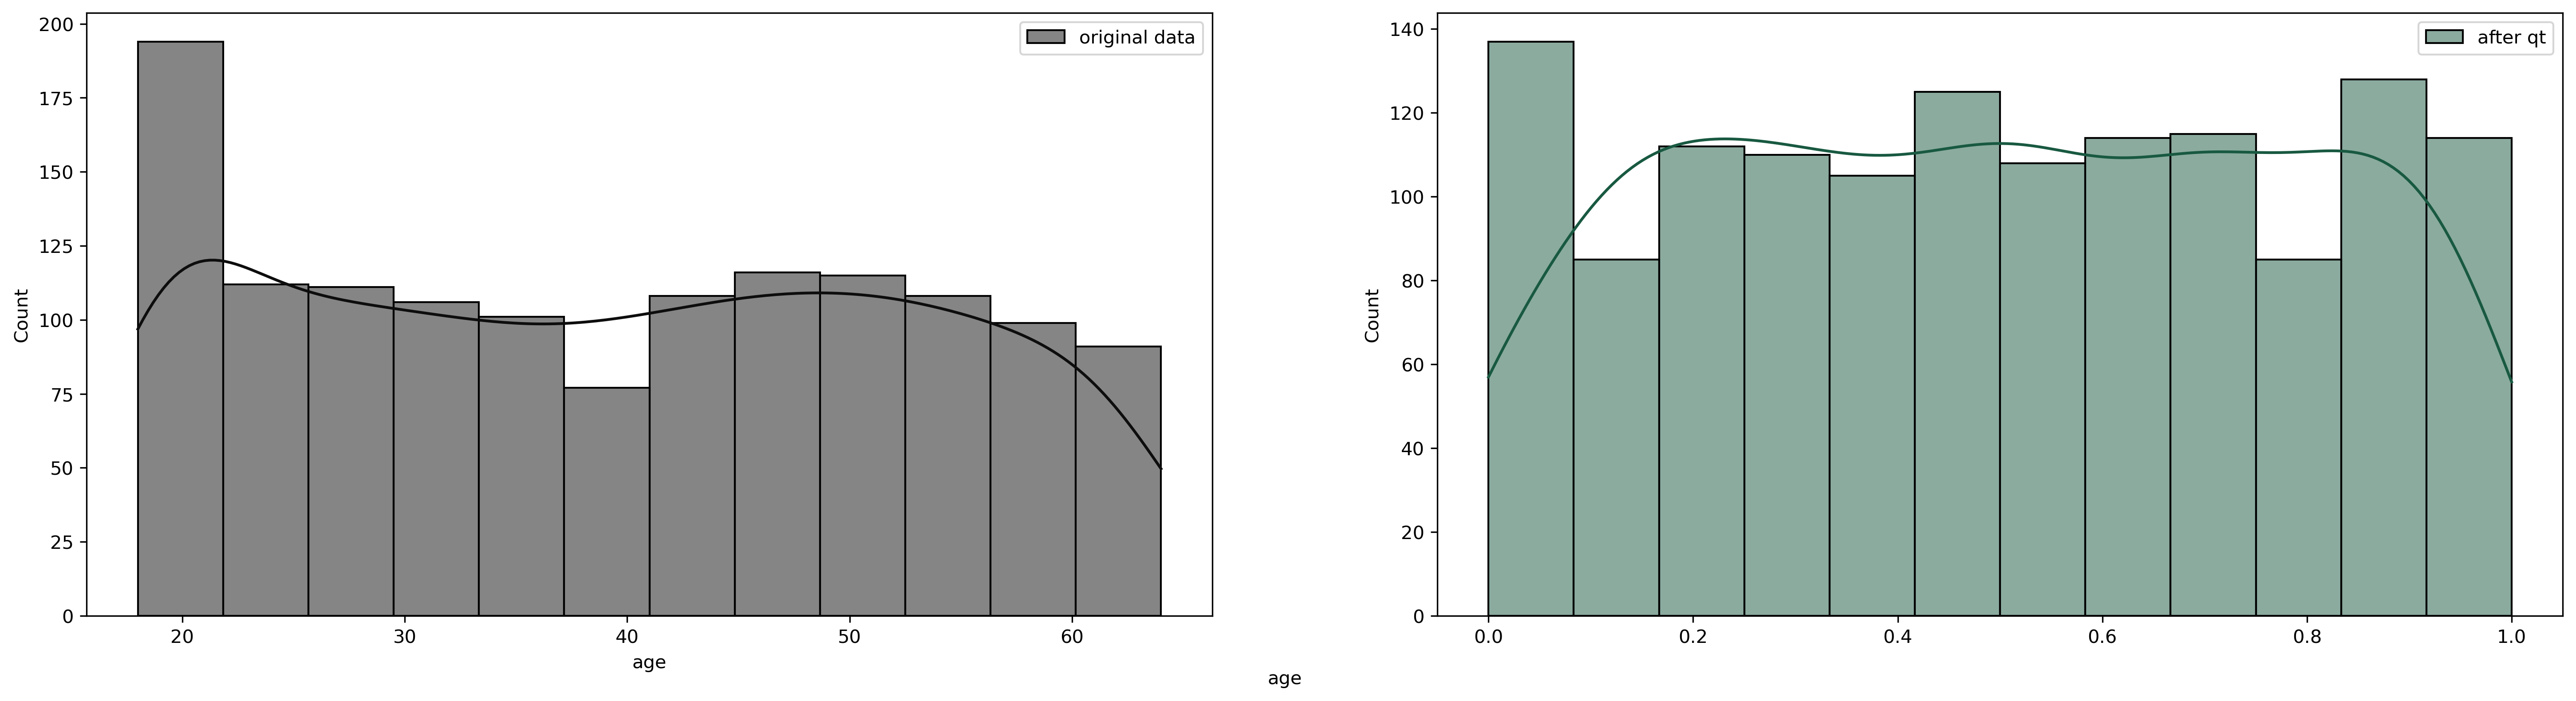

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[24, 6], dpi=300)
axes = axes.ravel()

sns.histplot(x=ins_data['age'], kde=True,
             color='#0D0D0D', label='original data',
             ax=axes[0])
axes[0].legend()
sns.histplot(x=after_transform_age[0], kde=True,
             color='#185941', label='after qt',
             ax=axes[1])
axes[1].legend()
fig.text(0.5, 0.04, 'age', ha='center')
plt.savefig('../../demo/Model Creation/age_qt.png')
plt.show()

In [29]:
power_transform = PowerTransformer(method='box-cox')

In [30]:
after_box_cox_trans_age = power_transform.fit_transform(np.asarray(ins_data['age']).reshape(-1, 1))
after_box_cox_trans_age = after_box_cox_trans_age.reshape(1, -1)
after_box_cox_trans_age

array([[-1.52664879, -1.61936837, -0.76169856, ..., -1.61936837,
        -1.34655034,  1.46397336]])

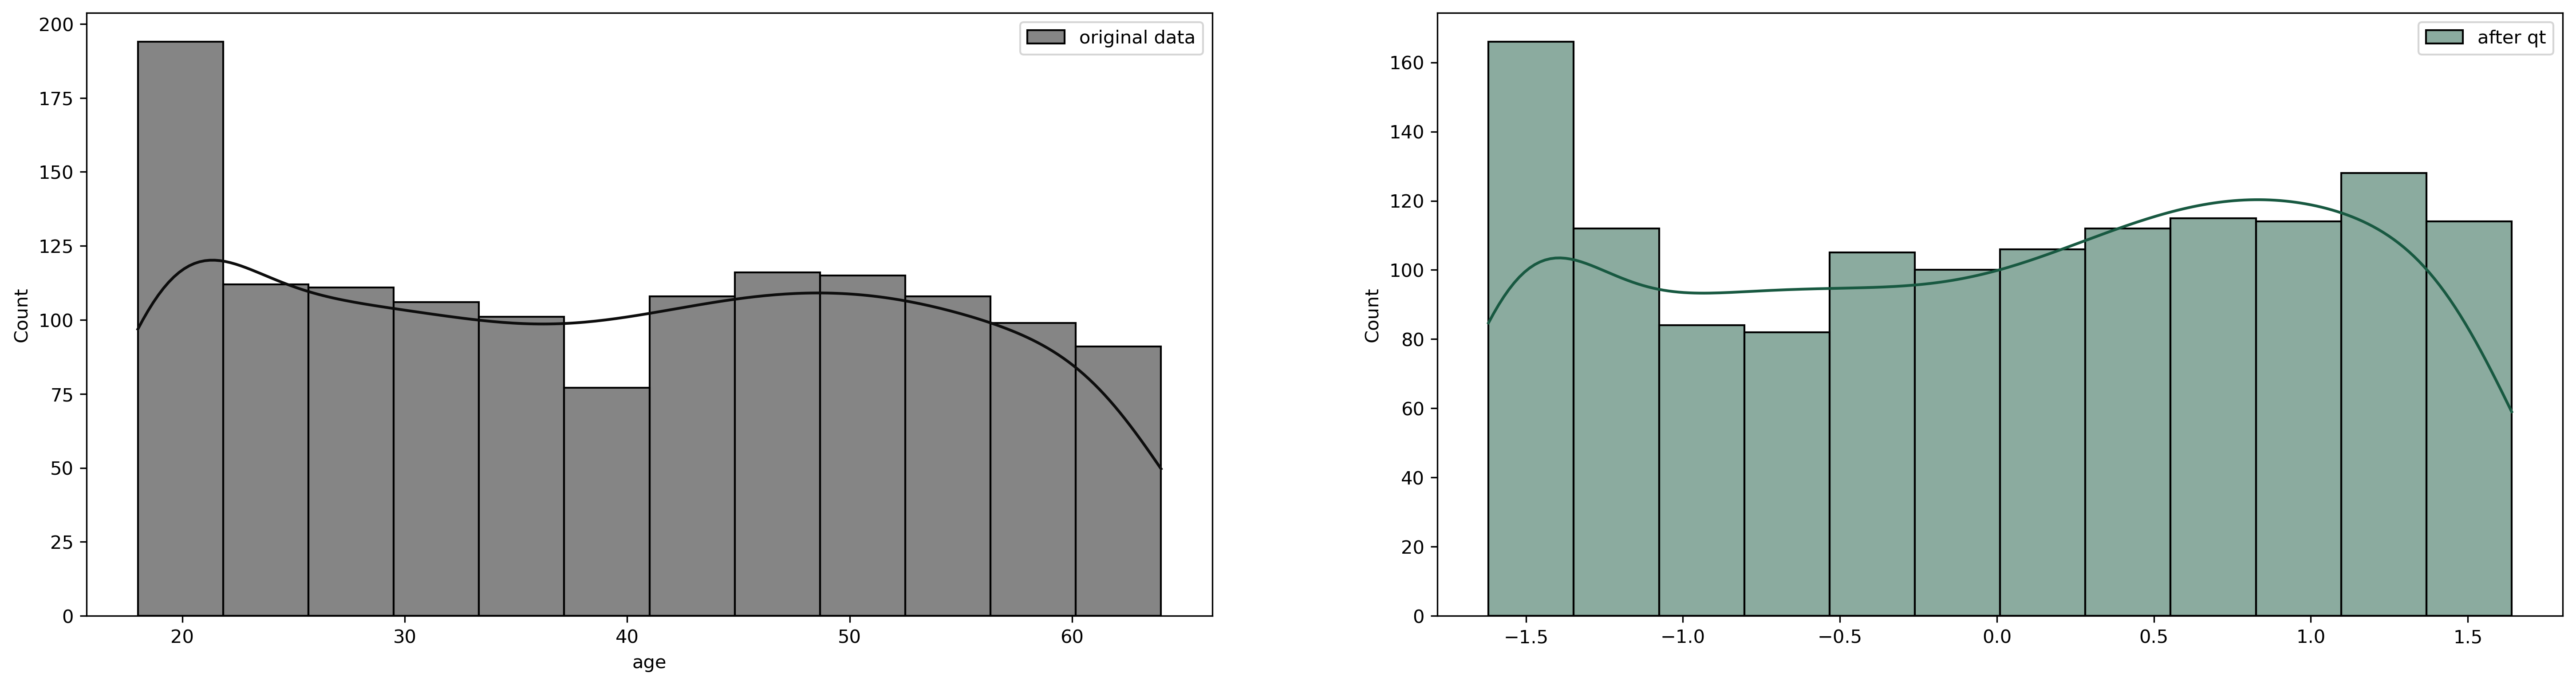

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[24, 6], dpi=300)
axes = axes.ravel()

sns.histplot(x=ins_data['age'], kde=True,
             color='#0D0D0D', label='original data',
             ax=axes[0])
axes[0].legend()
sns.histplot(x=after_box_cox_trans_age[0], kde=True,
             color='#185941', label='after qt',
             ax=axes[1])
axes[1].legend()
plt.savefig('../../demo/Model Creation/age_box_cox.png')
plt.show()